<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">

# Accelerating End-to-End Data Science Workflows # 

## 06 - Data Visualization ##

**Table of Contents**
<br>
This notebook demonstrates the basics of data visualization for large datasets. This notebook covers the below sections: 
1. [Data Visualization](#Data-Visualization)
2. [Bar Chart](#Bar-Chart)
    * [Histogram](#Histogram)
    * [Exercise #1 - Bar Chart](#Exercise-#1---Bar-Chart)
3. [Scatter Plot](#Scatter-Plot)
4. [Line Chart](#Line-Chart)
5. [Datashader](#Datashader)
    * [Datashader Accelerated by GPU](#Datashader-Accelerated-by-GPU)
6. [Interactive Visualization](#Interactive-Visualization)
    * [cuxfilter and Dashboard](#cuxfilter-and-Dashboard)
6. [Other Libraries](#Other-Libraries)

## Data Visualization ##
Data visualization is an important part of data science for several reasons: 
* **Data exploration**: enables data scientists to explore data and quickly identify patterns, trends, and outliers that may not be apparent when looking at raw data in tabular format
* **Interpretation**: transforms large and complex datasets into more digestible visual formats, making it easier to comprehend vast amounts of information
* **Communication**: helps data scientists communicate complex insights to stakeholders in an easy-to-understand visual format, making data more accessible to non-technical audiences

Below is the simple dashboard we will create in this notebook: 

<p><img src='images/dashboard_1_sample.png' width=720></p>

In [1]:
%load_ext cudf.pandas
# DO NOT CHANGE THIS CELL
import pandas as pd

dtype_dict={
    'age': 'int8', 
    'sex': 'object', 
    'county': 'object', 
    'lat': 'float32', 
    'long': 'float32', 
    'name': 'object'
}
        
df=pd.read_csv('./data/uk_pop.csv', dtype=dtype_dict)
df.head()

,age,sex,county,lat,long,name
0,0,m,DARLINGTON,54.533638,-1.524400,FRANCIS
1,0,m,DARLINGTON,54.426254,-1.465314,EDWARD
2,0,m,DARLINGTON,54.555199,-1.496417,TEDDY
3,0,m,DARLINGTON,54.547909,-1.572342,ANGUS
4,0,m,DARLINGTON,54.477638,-1.605995,CHARLIE


## Bar Chart ##
Bar charts are used to show and compare categorical data. It represent numercial values with rectangular bars where the length or height of each bar corresponds to the value it represents. 

Below we show the top 5 counties with the most people. 

<Axes: xlabel='county'>

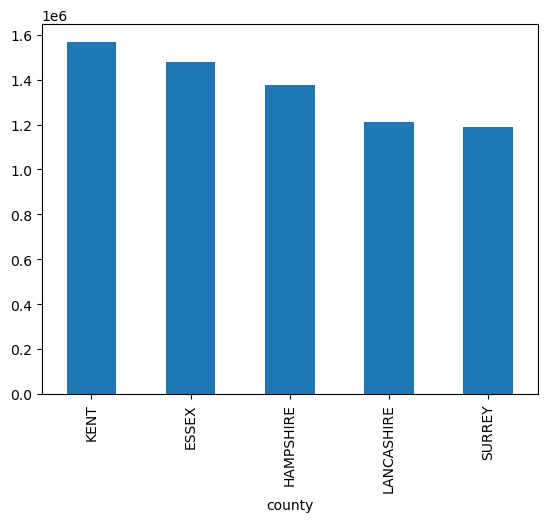

In [2]:
# DO NOT CHANGE THIS CELL
df.groupby('county').size().sort_values(ascending=False).head().plot(kind='bar')

### Histogram ###
Bar charts can also be used to show the distribution of data points across different subgroups. This is referred to as a historgram, which is done by counting the number of occurrences (frequency distribution) of each unique value in a dataset. It is used to visualize the shape, center, and spread of a dataset. 

<Axes: xlabel='age_bucket'>

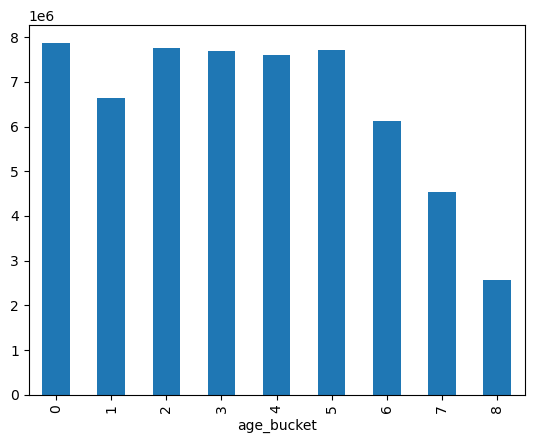

In [3]:
# DO NOT CHANGE THIS CELL
bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
df['age_bucket']=pd.cut(df['age'], bins=bins, right=True, include_lowest=True, labels=False)
df.groupby('age_bucket').size().plot(kind='bar')

### Exercise #1 - Bar Chart ###
We would like to find the distribution of sex in the population. 

**Instructions**: <br>
* Modify the `<FIXME>` only and execute the below cell plot the number of each sex in our dataset. 

<Axes: xlabel='sex'>

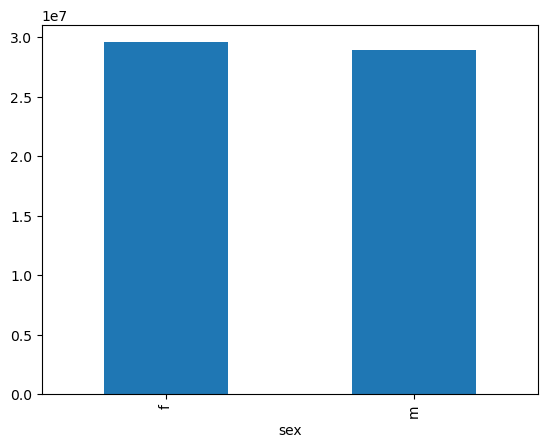

In [5]:
df.groupby('sex').size().plot(kind='bar')

Click ... for solution. 

## Scatter Plot ##
The scatter plot is used to show the relationship between two variables in a dataset. It can also be used to display coordinates of each data point to help identify outliers or clusters. 

<Axes: xlabel='lat', ylabel='long'>

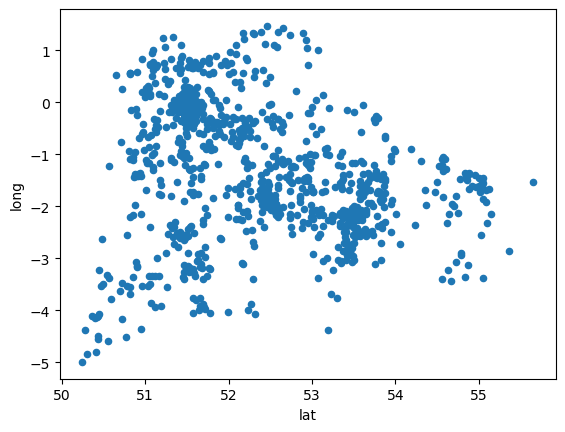

In [6]:
# DO NOT CHANGE THIS CELL
# sample a very small percentage of the data
small_df=df.sample(1000)

small_df.plot(kind='scatter', x='lat', y='long')

## Line Chart ##
Line charts are good for connecting individual data points to show trends. It's useful for visualizing changes, trends, and patterns over time. 

The scatter plot doesn't scale well with the number of data points. When the data becomes large, the scatter plot take a long time to complete. Below is line chart of the compute time for different data sizes. 

<p><img src='images/scatter_time.png', width=480></p>

**Note**: Below is the code used to produce this image. 

In [7]:
# import time
# import matplotlib.pyplot as plt

# fig, ax=plt.subplots()
# exec_times={}

# for size in (5*(10**i) for i in range(1, 8)): 
#     start=time.time()
#     df.sample(size).plot(kind='scatter', x='long', y='lat', ax=ax)
#     duration=time.time()-start
#     exec_times[size]=duration
#     ax.clear()

# ax.plot(exec_times.keys(), exec_times.values(), marker='o')
# ax.set_xscale('log')
# ax.set_xlabel('Data Size')
# ax.set_ylabel('Execution Time')
# ax.set_title("Scatter Plot Doesn't Scale Well With Data Size")

In [8]:
# DO NOT CHANGE THIS CELL
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Datashader ##
[Datashader](https://datashader.org/#) is an open-source Python library for analyzing and visualizing large datasets. Specifically, Datashader is designed to "rasterize" or "aggregate" datasets into regular grids that can be analyzed further or viewed as images, making it simple and quick to see the properties and patterns of data. 

Plotting for big data is challenging because rendering a large number of points takes a long time. Datashader shifts the burden of visualization from rendering to computing. Underneath the hood, it turns a long list of (x, y) points into a 2D histogram instead of plotting each point individually. Furthermore, this aggregation can be accelerated through parallel computing. The resulting gridded data structure is then turn into an image, using color to show the magnitude, before being embedding into a plotting program. 

Datashader generates a plot using a five-step [pipeline](https://datashader.org/getting_started/Pipeline.html): 

<p><img src='images/ds_pipeline.png' width=720></p>

Below we demonstrate how Datashader is used. 

In [9]:
# DO NOT CHANGE THIS CELL
import time
import matplotlib.pyplot as plt

import datashader as ds
import datashader.transfer_functions as tf

In [10]:
# DO NOT CHANGE THIS CELL
import pandas as pd

dtype_dict={
    'age': 'int8', 
    'sex': 'object', 
    'county': 'object', 
    'lat': 'float32', 
    'long': 'float32', 
    'name': 'object'
}
        
df=pd.read_csv('./data/uk_pop.csv', dtype=dtype_dict)
df.head()

,age,sex,county,lat,long,name
0,0,m,DARLINGTON,54.533638,-1.524400,FRANCIS
1,0,m,DARLINGTON,54.426254,-1.465314,EDWARD
2,0,m,DARLINGTON,54.555199,-1.496417,TEDDY
3,0,m,DARLINGTON,54.547909,-1.572342,ANGUS
4,0,m,DARLINGTON,54.477638,-1.605995,CHARLIE


<xarray.DataArray (lat: 600, long: 600)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
Coordinates:
  * long     (long) float64 5kB -6.361 -6.346 -6.331 ... 2.662 2.677 2.693
  * lat      (lat) float64 5kB 49.52 49.54 49.55 49.56 ... 56.23 56.24 56.26
Attributes:
    x_range:  (-6.368373870849609, 2.7000911235809326)
    y_range:  (49.519039154052734, 56.261409759521484)

Duration: 2.4 seconds


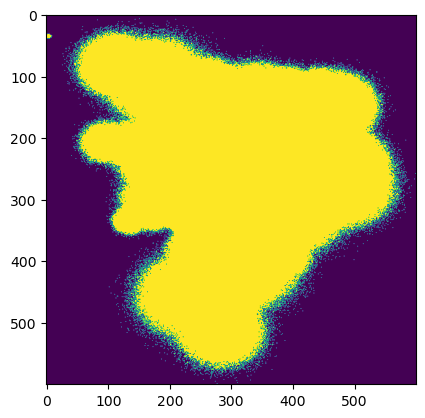

In [11]:
# DO NOT CHANGE THIS CELL
start=time.time()

# get points
ds_points_pandas=ds.Canvas().points(df,'long','lat')
display(ds_points_pandas)

# plot points
plt.imshow(tf.shade(ds_points_pandas))

print(f'Duration: {round(time.time()-start, 2)} seconds')

### Datashader Accelerated by GPU ###
Datashader can be accelerated by assigning the computation to a GPU. As previously mentioned, the GPU typically has far more (though individually less powerful) cores available than a CPU does, and for highly parallelizable computations like those in Datashader a GPU can typically achieve much faster performance at a given price point than a CPU or distributed set of CPUs can. The DataFrame from cuDF can be used as a replacement for rasterization. The performance benefits are significant since the entire data-processing pipeline is executed on the GPU and there is no bottleneck from data transfer. 

In [12]:
# DO NOT CHANGE THIS CELL
import cudf

dtype_dict={
    'age': 'int8', 
    'sex': 'object', 
    'county': 'object', 
    'lat': 'float32', 
    'long': 'float32', 
    'name': 'object'
}
        
gdf=cudf.read_csv('./data/uk_pop.csv', dtype=dtype_dict)
gdf.head()

,age,sex,county,lat,long,name
0,0,m,DARLINGTON,54.533638,-1.524400,FRANCIS
1,0,m,DARLINGTON,54.426254,-1.465314,EDWARD
2,0,m,DARLINGTON,54.555199,-1.496417,TEDDY
3,0,m,DARLINGTON,54.547909,-1.572342,ANGUS
4,0,m,DARLINGTON,54.477638,-1.605995,CHARLIE


<xarray.DataArray (lat: 600, long: 600)> Size: 1MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
Coordinates:
  * long     (long) float64 5kB -6.361 -6.346 -6.331 ... 2.662 2.677 2.693
  * lat      (lat) float64 5kB 49.52 49.54 49.55 49.56 ... 56.23 56.24 56.26
Attributes:
    x_range:  (-6.368374, 2.7000911)
    y_range:  (49.51904, 56.26141)

Duration: 14.92 seconds


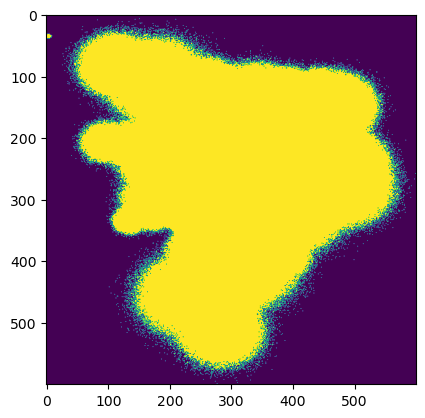

In [13]:
# DO NOT CHANGE THIS CELL
start=time.time()

# get points
ds_points_cudf=ds.Canvas().points(gdf,'long','lat')
display(ds_points_cudf)

# plot points
plt.imshow(tf.shade(ds_points_cudf))

print(f'Duration: {round(time.time()-start, 2)} seconds')

**Note**: Please re-execute the above cell if it took more than a few seconds for the more accurate compute time. 

## Interactive Visualization ##
Data visualization is crucial in data science as it bridges the gap between complex data and human understanding, making insights more accessible, actionable, and impactful throughout the data science process. Bringing interactivity in data visualization further enables: 
* **Discovery**: enables discovery of hidden patterns, trends, and outliers that may not be apparant in static visualizations
* **Enhanced understanding**: allows users to view data from multiple perspective and levels of detail
* **Customization**: provides the ability to rapidly filter, sort, and aggregate data, leading to a more impactful presentation

### cuxfilter and Dashboard ###
cuxfilter enables GPU accelerated cross-filtering dashboards, which is ideal for multi-chart exploratory data analysis. Cross-filtering lets users interact with one chart and apply that interaction as a filter to other charts in the dashboard. 

cuxfilter acts as a connector library, which provides the connections between different visualization libraries and a GPU DataFrame without much hassle. This also allows users to use charts from different libraries in a single dashboard, while also providing the interaction. Currently, cuxfilter supports: 
* [Bokeh](https://bokeh.org/) Charts
    * Bar chart
    * Line chart
    * Choropleth
* [Datashader](https://datashader.org/) Charts
    * Line
    * Scatter
* [Panel Widgets](https://panel.holoviz.org/api/panel.widgets.html)
    * Range
    * Float
    * Int
    * Dropdown
    * Multiselect

In [ ]:
import cuxfilter as cxf

# factorize county for multiselect widget
gdf['county'], county_names = gdf['county'].factorize()
county_map = dict(zip(list(range(len(county_names))), county_names.to_arrow()))

In [ ]:
# create cuxfilter DataFrame
cxf_data = cxf.DataFrame.from_dataframe(gdf)

# create Datashader scatter plot
scatter_chart = cxf.charts.scatter(x='long', y='lat')

In [ ]:
# create Bokeh bar charts
chart_3=cxf.charts.bar('age')
chart_2=cxf.charts.bar('sex')

In [ ]:
# define layout
layout_array=[[1, 2, 2], 
              [3, 2, 2]]

In [ ]:
# create multiselect widget
county_widget = cxf.charts.panel_widgets.multi_select('county', label_map=county_map)

# define layout
dash = cxf_data.dashboard(charts=[chart_2, scatter_chart, chart_3],sidebar=[county_widget], theme=cxf.themes.dark, data_size_widget=True, layout_array=layout_array)

dash.app()

## Other Libraries ##
* Plotly:
    * https://dash.plotly.com/holoviews#gpu-accelerating-datashader-and-linked-selections-with-rapids
    * https://developer.nvidia.com/blog/making-a-plotly-dash-census-viz-powered-by-rapids/

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

**Well Done!** Let's move to the [next notebook](1-07_etl.ipynb). 

<img src="images/nvidia_header.png" style="margin-left: -30px; width: 300px; float: left;">